In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings 
from category_encoders import TargetEncoder
from sklearn.preprocessing import LabelEncoder
warnings.filterwarnings("ignore")
import joblib
from joblib import dump
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from datetime import datetime

In [2]:
calendar_events = pd.read_csv('../../data/raw/calendar_events.csv',low_memory=False)

In [3]:
calendar = pd.read_csv('../../data/raw/calendar.csv',low_memory=False)

In [4]:
items_weekly_sell_prices = pd.read_csv('../../data/raw/items_weekly_sell_prices.csv',low_memory=False)

In [5]:
sales_train = pd.read_csv('../../data/raw/sales_train.csv',low_memory=False)

In [6]:
calendar_events

,date,event_name,event_type
0,2011-02-06,SuperBowl,Sporting
1,2011-02-14,ValentinesDay,Cultural
2,2011-02-21,PresidentsDay,National
3,2011-03-09,LentStart,Religious
4,2011-03-16,LentWeek2,Religious
...,...,...,...
162,2016-05-30,MemorialDay,National
163,2016-06-02,NBAFinalsStart,Sporting
164,2016-06-07,Ramadan starts,Religious
165,2016-06-19,Father's day,Cultural


In [7]:
items_weekly_sell_prices

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26
...,...,...,...,...
6841116,WI_3,FOODS_3_827,11617,1.00
6841117,WI_3,FOODS_3_827,11618,1.00
6841118,WI_3,FOODS_3_827,11619,1.00
6841119,WI_3,FOODS_3_827,11620,1.00


In [8]:
sales_train

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1532,d_1533,d_1534,d_1535,d_1536,d_1537,d_1538,d_1539,d_1540,d_1541
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,1,1,0,1,0,1,0,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,8,2,0,8,2,3,1,1,3,8
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,0,1,3,2,1,1,2,2,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS_3_823_WI_3_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,0,0,2,2,...,1,2,0,0,0,1,0,0,0,2
30486,FOODS_3_824_WI_3_evaluation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,0,0,0,0,0,0,12,0,0,0
30487,FOODS_3_825_WI_3_evaluation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,0,6,0,2,...,1,0,3,2,1,1,0,1,3,0
30488,FOODS_3_826_WI_3_evaluation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
# Obtain a NumPy array of unique 'item_id' values from the 'sales_train' DataFrame
unique_item_ids_array = sales_train['item_id'].unique()

# Convert the NumPy array to a Python list
unique_item_list = unique_item_ids_array.tolist()

# Create a DataFrame using the list, with 'item_id' as the column name
df = pd.DataFrame({'item_id': unique_item_list})

# Define the file path where the CSV file will be saved
csv_file_path = '../../data/processed/unique_item_list.csv'

# Save the DataFrame to a CSV file at the specified path, excluding the index column
df.to_csv(csv_file_path, index=False)


In [10]:
# Melt the DataFrame to reshape it
sales_train_melted = pd.melt(sales_train, id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'],
                    var_name='day', value_name='item_sales')

In [11]:
sales_train_melted.shape

(46985090, 8)

In [12]:
sales_train_melted

,id,item_id,dept_id,cat_id,store_id,state_id,day,item_sales
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
...,...,...,...,...,...,...,...,...
46985085,FOODS_3_823_WI_3_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,d_1541,2
46985086,FOODS_3_824_WI_3_evaluation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,d_1541,0
46985087,FOODS_3_825_WI_3_evaluation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,d_1541,0
46985088,FOODS_3_826_WI_3_evaluation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,d_1541,0


In [13]:
# Merge the two DataFrames based on the 'day' and 'd' columns
merged_df = sales_train_melted.merge(calendar[['d', 'date', 'wm_yr_wk']], left_on='day', right_on='d', how='left')

In [14]:
# calendar_events = pd.DataFrame(calendar_events.groupby('date').size().reset_index(name='event_count'))

In [15]:
# merged_df = merged_df.merge(calendar_events, on='date', how='left')

In [16]:
merged_df = merged_df.merge(items_weekly_sell_prices[['store_id', 'item_id', 'wm_yr_wk', 'sell_price']], 
                            on=['store_id', 'item_id', 'wm_yr_wk'], how='left')
merged_df

,id,item_id,dept_id,cat_id,store_id,state_id,day,item_sales,d,date,wm_yr_wk,sell_price
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,d_1,2011-01-29,11101,NaN
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,d_1,2011-01-29,11101,NaN
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,d_1,2011-01-29,11101,NaN
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,d_1,2011-01-29,11101,NaN
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,d_1,2011-01-29,11101,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
46985085,FOODS_3_823_WI_3_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,d_1541,2,d_1541,2015-04-18,11512,2.88
46985086,FOODS_3_824_WI_3_evaluation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,d_1541,0,d_1541,2015-04-18,11512,2.00
46985087,FOODS_3_825_WI_3_evaluation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,d_1541,0,d_1541,2015-04-18,11512,3.98
46985088,FOODS_3_826_WI_3_evaluation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,d_1541,0,d_1541,2015-04-18,11512,1.28


In [17]:
del calendar_events
del calendar
del items_weekly_sell_prices
del sales_train
del sales_train_melted

In [18]:
# merged_df['is_event'] = (merged_df['event_count'] > 0).astype(int)
# merged_df = merged_df.drop('event_count', axis=1)

In [19]:
merged_df['revenue'] = merged_df['item_sales']*merged_df['sell_price']
merged_df['revenue'].fillna(0, inplace=True)
merged_df['sell_price'].fillna(0, inplace=True)

In [20]:
col = ['item_id','store_id','date','revenue']
merged_df = merged_df[col]
merged_df

,item_id,store_id,date,revenue
0,HOBBIES_1_001,CA_1,2011-01-29,0.00
1,HOBBIES_1_002,CA_1,2011-01-29,0.00
2,HOBBIES_1_003,CA_1,2011-01-29,0.00
3,HOBBIES_1_004,CA_1,2011-01-29,0.00
4,HOBBIES_1_005,CA_1,2011-01-29,0.00
...,...,...,...,...
46985085,FOODS_3_823,WI_3,2015-04-18,5.76
46985086,FOODS_3_824,WI_3,2015-04-18,0.00
46985087,FOODS_3_825,WI_3,2015-04-18,0.00
46985088,FOODS_3_826,WI_3,2015-04-18,0.00


In [21]:
merged_df = merged_df[merged_df['revenue']<=300]

In [22]:
# revenue_zero = merged_df['revenue'] != 0
# df_cleaned = merged_df[revenue_zero]
df_cleaned = merged_df.copy()
del merged_df
df_cleaned

,item_id,store_id,date,revenue
0,HOBBIES_1_001,CA_1,2011-01-29,0.00
1,HOBBIES_1_002,CA_1,2011-01-29,0.00
2,HOBBIES_1_003,CA_1,2011-01-29,0.00
3,HOBBIES_1_004,CA_1,2011-01-29,0.00
4,HOBBIES_1_005,CA_1,2011-01-29,0.00
...,...,...,...,...
46985085,FOODS_3_823,WI_3,2015-04-18,5.76
46985086,FOODS_3_824,WI_3,2015-04-18,0.00
46985087,FOODS_3_825,WI_3,2015-04-18,0.00
46985088,FOODS_3_826,WI_3,2015-04-18,0.00


In [23]:
df_cleaned['date'] = pd.to_datetime(df_cleaned['date'])
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 46983216 entries, 0 to 46985089
Data columns (total 4 columns):
 #   Column    Dtype         
---  ------    -----         
 0   item_id   object        
 1   store_id  object        
 2   date      datetime64[ns]
 3   revenue   float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 1.8+ GB


In [24]:
# Extract the year, month, day and day of the week into new columns
df_cleaned['year'] = df_cleaned['date'].dt.year
df_cleaned['month'] = df_cleaned['date'].dt.month
df_cleaned['day'] = df_cleaned['date'].dt.day
df_cleaned['day_of_week'] = df_cleaned['date'].dt.strftime('%A')

In [25]:
col_list = ['item_id', 'store_id', 'year', 'month', 'day', 'day_of_week', 'revenue']
df_cleaned = df_cleaned[col_list]
df_cleaned

,item_id,store_id,year,month,day,day_of_week,revenue
0,HOBBIES_1_001,CA_1,2011,1,29,Saturday,0.00
1,HOBBIES_1_002,CA_1,2011,1,29,Saturday,0.00
2,HOBBIES_1_003,CA_1,2011,1,29,Saturday,0.00
3,HOBBIES_1_004,CA_1,2011,1,29,Saturday,0.00
4,HOBBIES_1_005,CA_1,2011,1,29,Saturday,0.00
...,...,...,...,...,...,...,...
46985085,FOODS_3_823,WI_3,2015,4,18,Saturday,5.76
46985086,FOODS_3_824,WI_3,2015,4,18,Saturday,0.00
46985087,FOODS_3_825,WI_3,2015,4,18,Saturday,0.00
46985088,FOODS_3_826,WI_3,2015,4,18,Saturday,0.00


In [26]:
# Get unique store_id values
unique_store_ids = df_cleaned['store_id'].unique()

# Create separate dataframes for each store_id
store_dataframes = {}
for store_id in unique_store_ids:
    store_name = f'store_{store_id}'
    store_dataframes[store_name] = df_cleaned[df_cleaned['store_id'] == store_id].copy()
    store_dataframes[store_name].drop(columns=['store_id'], inplace=True)

del df_cleaned

In [27]:
unique_store_ids

array(['CA_1', 'CA_2', 'CA_3', 'CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1',
       'WI_2', 'WI_3'], dtype=object)

In [28]:
# Separate dataframes named store_CA_1, store_CA_2, store_WI_2, etc. for each store
store_CA_1 = store_dataframes['store_CA_1']
store_CA_2 = store_dataframes['store_CA_2']
store_CA_3 = store_dataframes['store_CA_3']
store_CA_4 = store_dataframes['store_CA_4']
store_TX_1 = store_dataframes['store_TX_1']
store_TX_2 = store_dataframes['store_TX_2']
store_TX_3 = store_dataframes['store_TX_3']
store_WI_1 = store_dataframes['store_WI_1']
store_WI_2 = store_dataframes['store_WI_2']
store_WI_3 = store_dataframes['store_WI_3']

In [29]:
store_CA_1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4698146 entries, 0 to 46957648
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   item_id      object 
 1   year         int32  
 2   month        int32  
 3   day          int32  
 4   day_of_week  object 
 5   revenue      float64
dtypes: float64(1), int32(3), object(2)
memory usage: 197.1+ MB


## Train Validation split

In [30]:
from sklearn.model_selection import train_test_split

# Create a dictionary of store dataframes
store_dataframes = {
    'store_CA_1': store_CA_1,
    'store_CA_2': store_CA_2,
    'store_CA_3': store_CA_3,
    'store_CA_4': store_CA_4,
    'store_TX_1': store_TX_1,
    'store_TX_2': store_TX_2,
    'store_TX_3': store_TX_3,
    'store_WI_1': store_WI_1,
    'store_WI_2': store_WI_2,
    'store_WI_3': store_WI_3
}

# Loop through each store dataframe
for store_name, store_df in store_dataframes.items():
    X = store_df.drop(columns=['revenue'])
    y = store_df['revenue']

    # Split the data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    # Create DataFrames for training and validation with store ID in variable name
    globals()[f'{store_name}_X_train'] = X_train.copy()
    globals()[f'{store_name}_y_train'] = y_train.copy()
    globals()[f'{store_name}_X_val'] = X_val.copy()
    globals()[f'{store_name}_y_val'] = y_val.copy()
    
    # Delete store dataframes
    del store_df

In [31]:
store_CA_1_X_train

,item_id,year,month,day,day_of_week
18936824,FOODS_3_310,2012,10,11,Thursday
30948931,HOUSEHOLD_2_486,2013,11,9,Saturday
20308866,FOODS_3_302,2012,11,25,Sunday
14241819,FOODS_3_768,2012,5,10,Thursday
30185385,HOBBIES_1_294,2013,10,15,Tuesday
...,...,...,...,...,...
11344139,FOODS_2_032,2012,2,5,Sunday
15674764,FOODS_3_680,2012,6,26,Tuesday
22321470,FOODS_3_566,2013,1,30,Wednesday
43024152,FOODS_3_538,2014,12,10,Wednesday


In [32]:
store_CA_1_y_train

18936824    4.00
30948931    0.00
20308866    4.50
14241819    0.00
30185385    0.00
            ... 
11344139    0.00
15674764    7.50
22321470    0.00
43024152    4.44
16922612    2.37
Name: revenue, Length: 3758516, dtype: float64

## Pipeline

In [33]:
# Import Pipeline from sklearn.pipeline, StandardScaler, OrdinalEncoder and OneHotEncoder 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.linear_model import SGDRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.base import BaseEstimator, TransformerMixin

In [34]:
cat_transformer = Pipeline(steps=[('one_hot_encoder', OneHotEncoder(sparse=False, drop='first'))])

In [35]:
target_transformer = Pipeline(steps=[('target_encoder', TargetEncoder(handle_unknown='value'))])

In [36]:
from sklearn.compose import ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cat_cols', cat_transformer, ['year','month','day','day_of_week']),
        ('tar_col', target_transformer, ['item_id'])
    ]
)

In [37]:
# List of store names
store_names = ['store_CA_1', 'store_CA_2', 'store_CA_3', 'store_CA_4', 'store_TX_1',
               'store_TX_2', 'store_TX_3', 'store_WI_1', 'store_WI_2', 'store_WI_3']

# Lists containing X_train, y_train, X_val, and y_val for all stores as strings
X_train_list = [
    'store_CA_1_X_train', 'store_CA_2_X_train', 'store_CA_3_X_train', 'store_CA_4_X_train',
    'store_TX_1_X_train', 'store_TX_2_X_train', 'store_TX_3_X_train',
    'store_WI_1_X_train', 'store_WI_2_X_train', 'store_WI_3_X_train'
]

y_train_list = [
    'store_CA_1_y_train', 'store_CA_2_y_train', 'store_CA_3_y_train', 'store_CA_4_y_train',
    'store_TX_1_y_train', 'store_TX_2_y_train', 'store_TX_3_y_train',
    'store_WI_1_y_train', 'store_WI_2_y_train', 'store_WI_3_y_train'
]

X_val_list = [
    'store_CA_1_X_val', 'store_CA_2_X_val', 'store_CA_3_X_val', 'store_CA_4_X_val',
    'store_TX_1_X_val', 'store_TX_2_X_val', 'store_TX_3_X_val',
    'store_WI_1_X_val', 'store_WI_2_X_val', 'store_WI_3_X_val'
]

y_val_list = [
    'store_CA_1_y_val', 'store_CA_2_y_val', 'store_CA_3_y_val', 'store_CA_4_y_val',
    'store_TX_1_y_val', 'store_TX_2_y_val', 'store_TX_3_y_val',
    'store_WI_1_y_val', 'store_WI_2_y_val', 'store_WI_3_y_val'
]

## LGBMRegressor

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016158 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 357
[LightGBM] [Info] Number of data points in the train set: 3758516, number of used features: 52
[LightGBM] [Info] Start training from score 3.646386


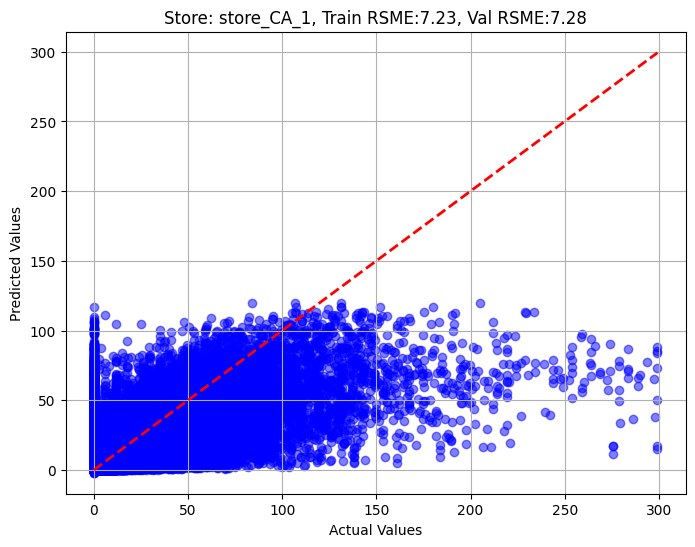

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015389 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 357
[LightGBM] [Info] Number of data points in the train set: 3758802, number of used features: 52
[LightGBM] [Info] Start training from score 2.714908


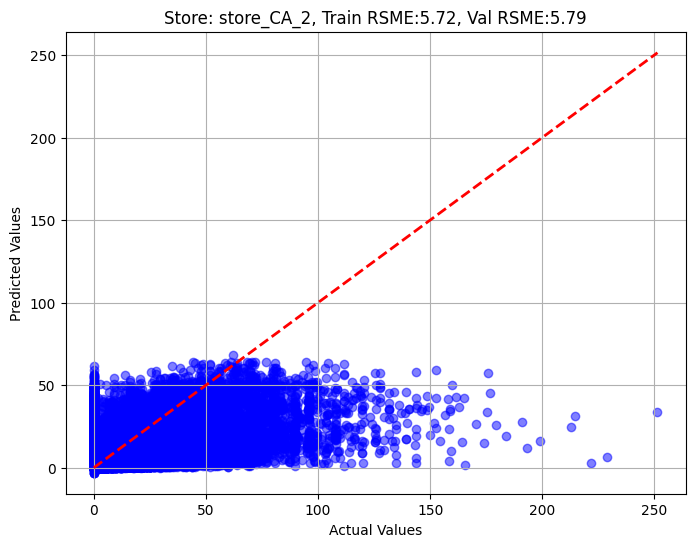

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016380 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 357
[LightGBM] [Info] Number of data points in the train set: 3758063, number of used features: 52
[LightGBM] [Info] Start training from score 5.197632


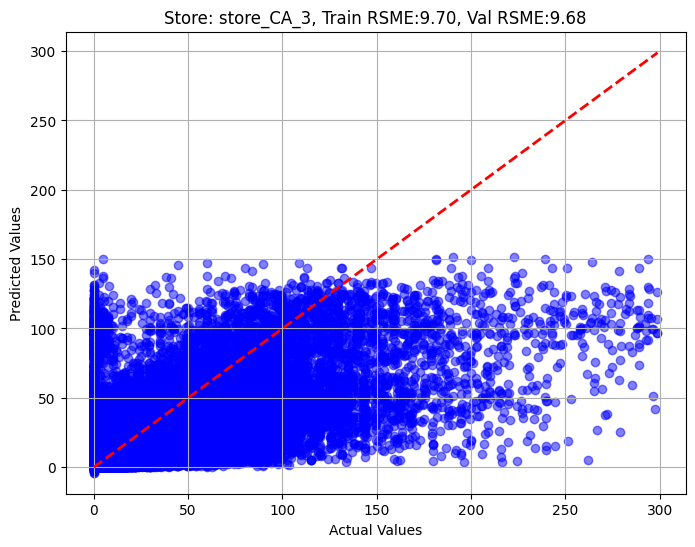

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017788 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 357
[LightGBM] [Info] Number of data points in the train set: 3758804, number of used features: 52
[LightGBM] [Info] Start training from score 1.974680


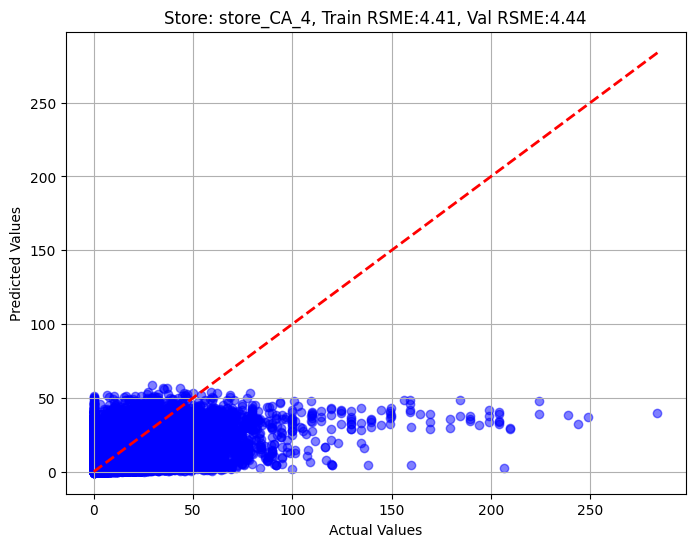

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014343 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 357
[LightGBM] [Info] Number of data points in the train set: 3758784, number of used features: 52
[LightGBM] [Info] Start training from score 2.572346


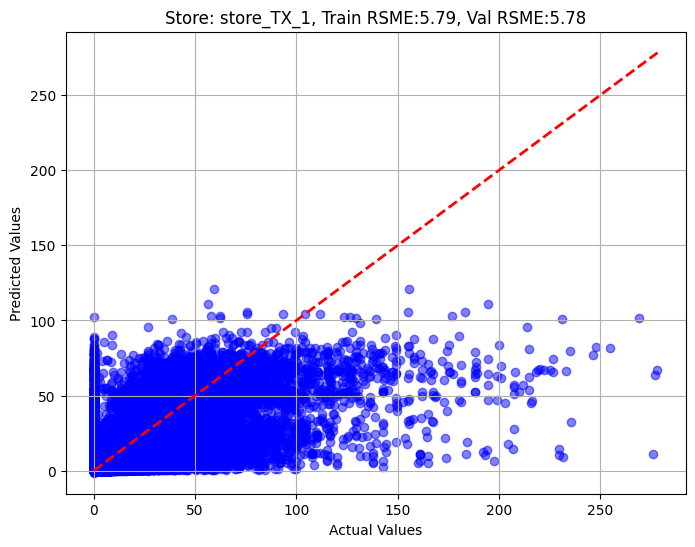

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015831 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 357
[LightGBM] [Info] Number of data points in the train set: 3758705, number of used features: 52
[LightGBM] [Info] Start training from score 3.398451


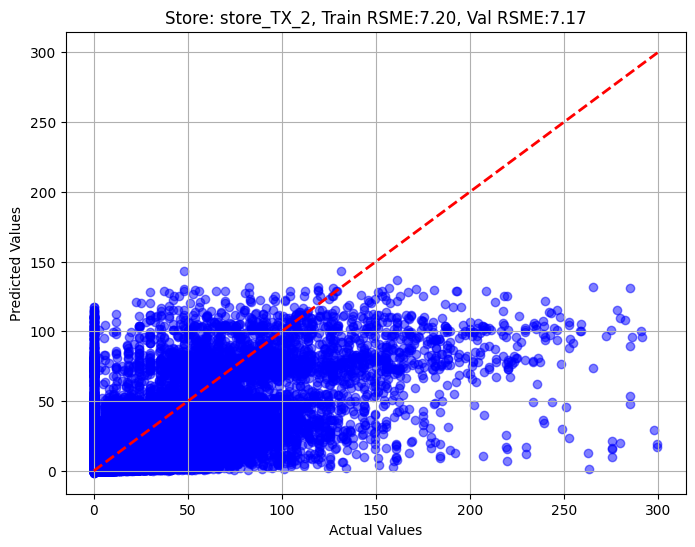

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012927 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 357
[LightGBM] [Info] Number of data points in the train set: 3758660, number of used features: 52
[LightGBM] [Info] Start training from score 2.786785


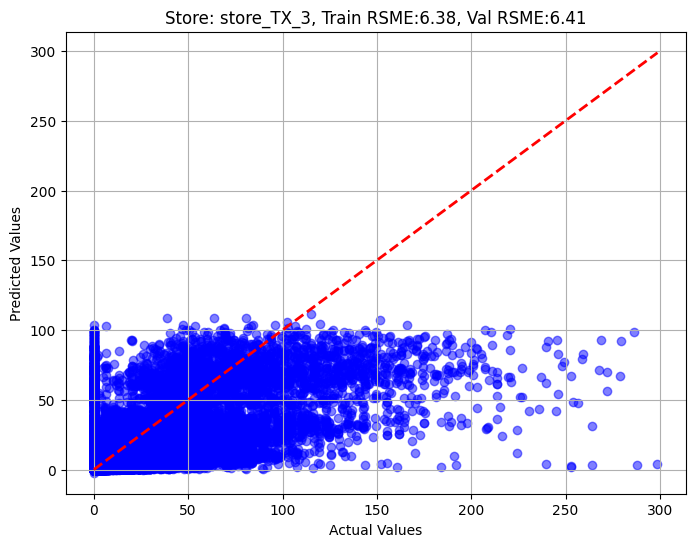

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017203 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 357
[LightGBM] [Info] Number of data points in the train set: 3758804, number of used features: 52
[LightGBM] [Info] Start training from score 2.295603


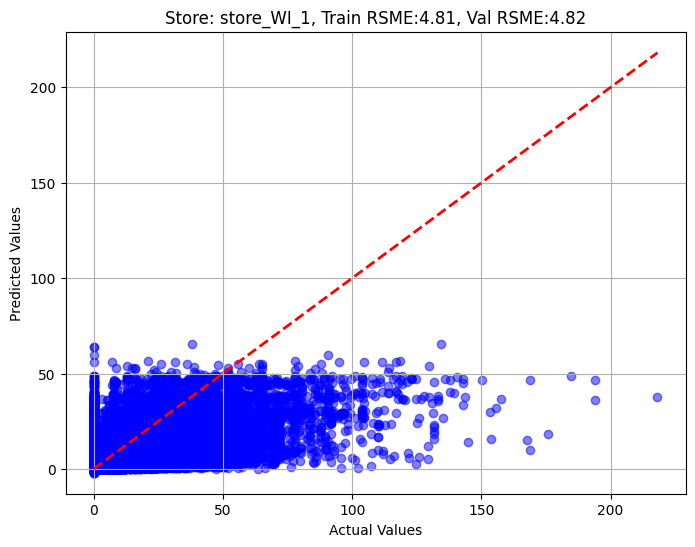

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018654 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 357
[LightGBM] [Info] Number of data points in the train set: 3758685, number of used features: 52
[LightGBM] [Info] Start training from score 2.740943


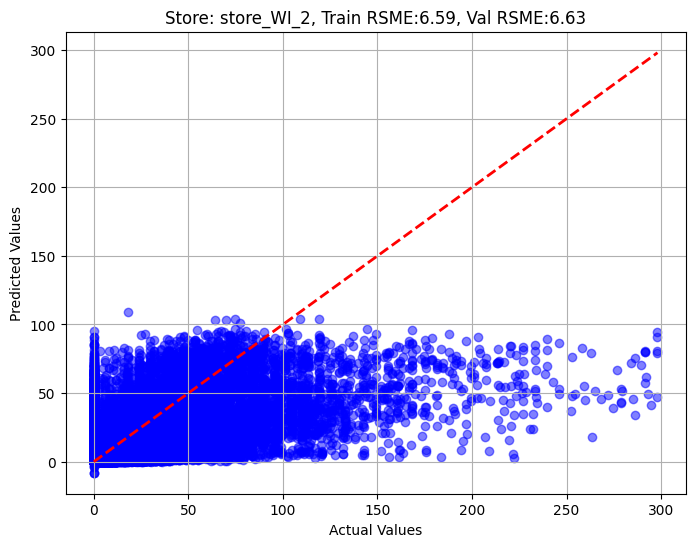

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020271 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 357
[LightGBM] [Info] Number of data points in the train set: 3758747, number of used features: 52
[LightGBM] [Info] Start training from score 2.832264


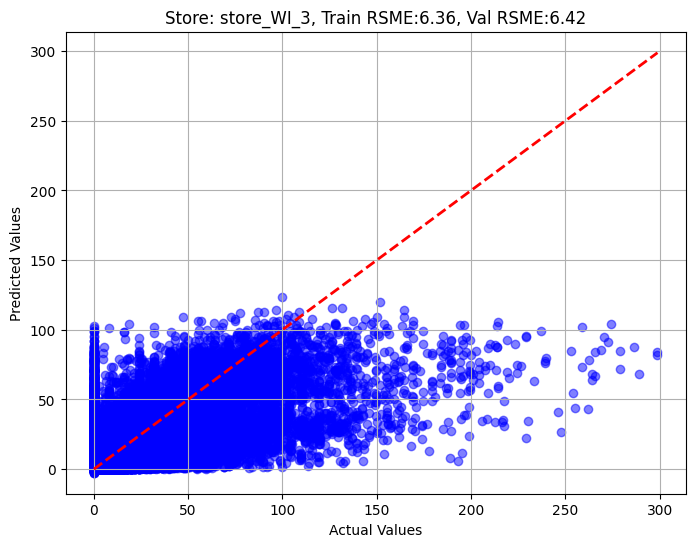

In [38]:
# Initialize a dictionary to store models and results for each store
store_models = {}
store_results = {}


# Loop through each store
for store_name in store_names:
    # Create a pipeline for each store
    lgb_pipe = Pipeline(
        steps=[
            ('preprocessor', preprocessor), 
            ('lgb', lgb.LGBMRegressor())
        ]
    )

    # Get the corresponding X_train, y_train, X_val, and y_val for this store
    X_train = globals()[f'{store_name}_X_train']
    y_train = globals()[f'{store_name}_y_train']
    X_val = globals()[f'{store_name}_X_val']
    y_val = globals()[f'{store_name}_y_val']

    # Train the LightGBM model for this store
    lgb_predictive_model = lgb_pipe.fit(X_train, y_train)

    # Store the trained model in the dictionary
    store_models[store_name] = lgb_predictive_model

    # Predict on training and validation data
    lgb_y_pred_train = lgb_pipe.predict(X_train)
    lgb_y_pred_val = lgb_pipe.predict(X_val)

    # Evaluate the model
    train_rmse = np.sqrt(mean_squared_error(y_train, lgb_y_pred_train))
    val_rmse = np.sqrt(mean_squared_error(y_val, lgb_y_pred_val))
    baseline = np.sqrt(mean_squared_error(pd.concat([y_train, y_val], axis=0), 
                                          pd.concat([pd.Series(lgb_y_pred_train), 
                                          pd.Series(lgb_y_pred_val)], axis=0)))


    # Store the results in the dictionary
    store_results[store_name] = {
        'baseline_rmse': baseline,       
        'train_rmse': train_rmse,
        'val_rmse': val_rmse
    }

    # Create a scatter plot for this store
    plt.figure(figsize=(8, 6))
    plt.scatter(y_val, lgb_y_pred_val, c='blue', marker='o', alpha=0.5)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Store: {store_name}, Train RSME:{train_rmse:.2f}, Val RSME:{val_rmse:.2f}')

    plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], color='red', linestyle='--', linewidth=2)

    plt.grid(True)
    plt.show()
    
    # Saving the fitted models 
    dump(lgb_predictive_model, f'../../models/predictive/lgbm_{store_name}.joblib')

In [39]:
lgb_rsme_df = pd.DataFrame(store_results).transpose()
lgb_rsme_df

,baseline_rmse,train_rmse,val_rmse
store_CA_1,7.242093,7.233376,7.276859
store_CA_2,5.735208,5.721615,5.789264
store_CA_3,9.695821,9.700983,9.675144
store_CA_4,4.415324,4.409242,4.439569
store_TX_1,5.785319,5.787674,5.775888
store_TX_2,7.192938,7.199415,7.166971
store_TX_3,6.388319,6.383801,6.406360
store_WI_1,4.808941,4.805001,4.824669
store_WI_2,6.594577,6.585164,6.632098
store_WI_3,6.373680,6.362419,6.418527
